In [3]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
#from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
sim_name = 'TNG100-1'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

In [16]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [17]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [18]:
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('v200m')

sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_minPE_hydro')

In [19]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
r_200m = np.array([dark_halo.catalog_properties['r200m'] for dark_halo in sim_reader.dark_halo_arr])
v_200m = np.array([dark_halo.catalog_properties['v200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)
log_r_200m = np.log10(r_200m)
N_halos = len(sim_reader.dark_halo_arr)
print('N_halos:', N_halos)

N_halos: 19670


# MAH from Illustris Sublink

In [72]:
#sim_reader.add_MAH_to_halos_sublink()

0
0 0
1000
1003 637821
2000
2004 713990
3000
3007 759746
4000
4014 791382
5000
5020 815717
6000
6024 835722
7000
7031 852398
8000
8040 866828
9000
9049 879559
10000
10068 891338
11000
11084 902126
12000
12102 911876
13000
13130 920900
14000
14149 929138
15000
15177 936970
16000
16209 944368
17000
17251 951674
18000
18320 958589
19000
19421 965553


In [37]:
def save_mah(halos, fn_mah):
    mah_dict = {}
    for halo in halos:
        mah_dict[halo.idx_halo_dark] = halo.catalog_properties['MAH']
    np.save(fn_mah, mah_dict)
    
def load_mah(halos, fn_mah):
    mah_dict = np.load(fn_mah, allow_pickle=True).item()
    for halo in halos:
        halo.set_catalog_property('MAH', mah_dict[halo.idx_halo_dark])

In [38]:
fn_mah = f'../data/mahs/mahs_{sim_name}{halo_tag}.npy'
# save_mah(sim_reader.dark_halo_arr, fn_mah)

In [39]:
load_mah(sim_reader.dark_halo_arr, fn_mah)

In [49]:
np.random.seed(14)
rand_idxs = np.random.randint(len(sim_reader.dark_halo_arr), size=10)

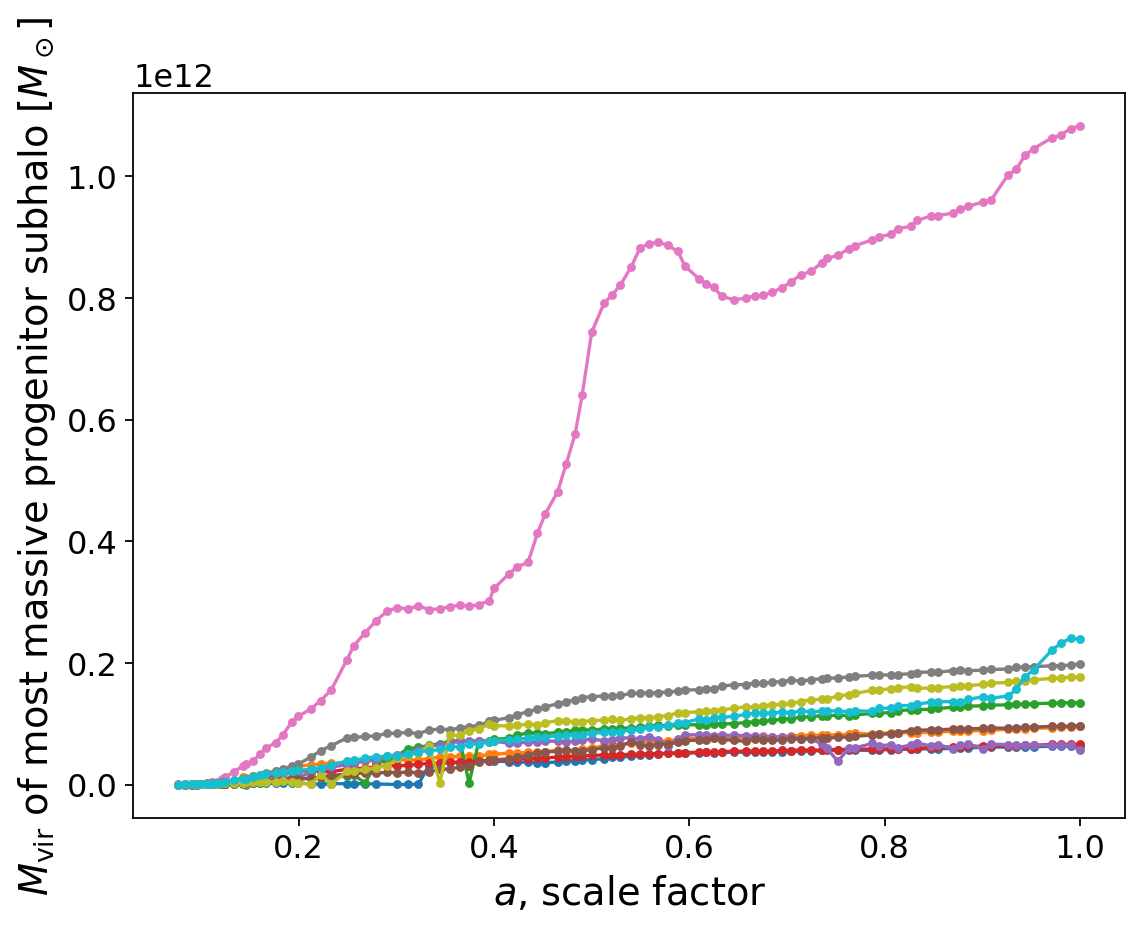

In [50]:
plt.figure(figsize=(8,6))
for i in rand_idxs:
    halo = sim_reader.dark_halo_arr[i]
    a_mah, m_mah = halo.catalog_properties['MAH']
    plt.plot(a_mah, m_mah*mass_multiplier, marker='o', markersize=3)
    plt.xlabel(r'$a$, scale factor')
    plt.ylabel(r'$M_\mathrm{vir}$ of most massive progenitor subhalo [$M_\odot$]')

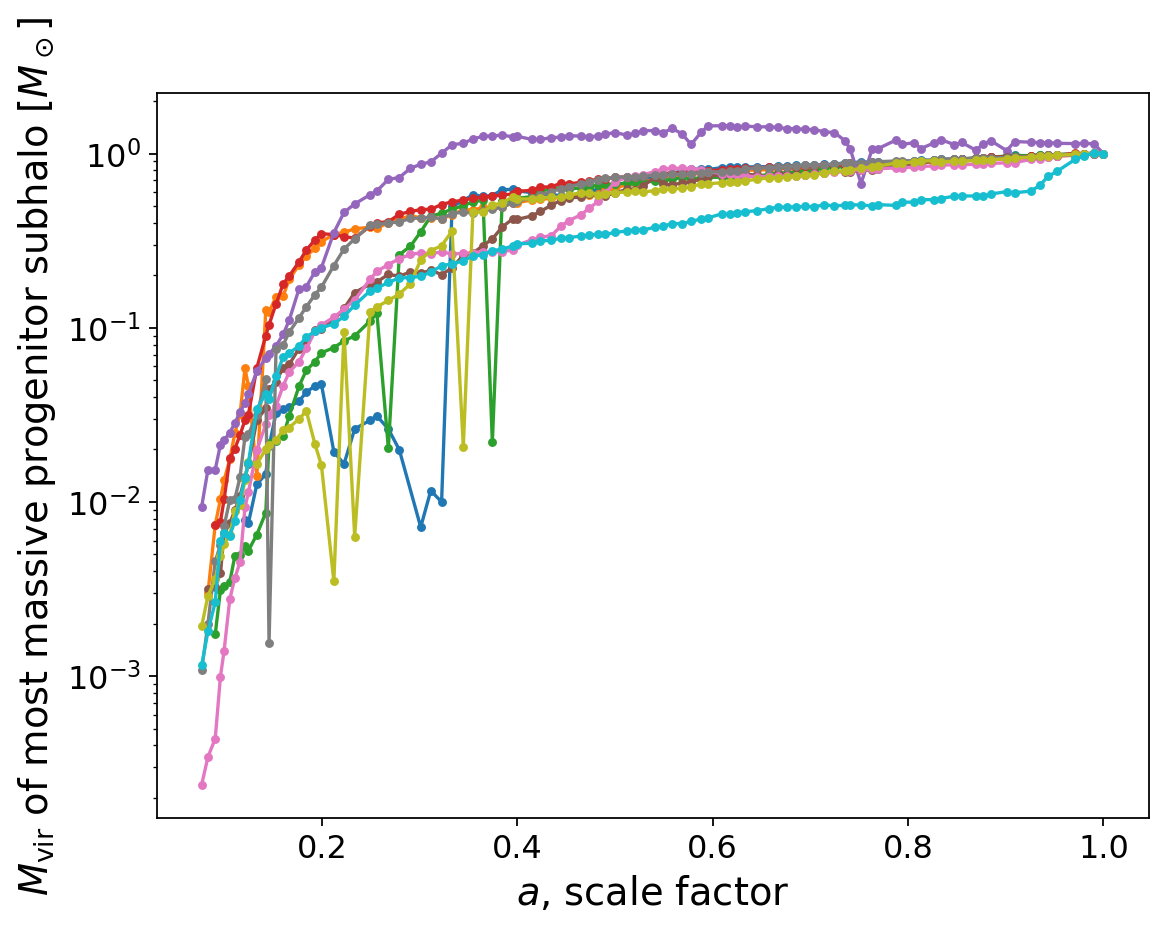

In [51]:
plt.figure(figsize=(8,6))
for i in rand_idxs:
    halo = sim_reader.dark_halo_arr[i]
    a_mah, m_mah = halo.catalog_properties['MAH']
    plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3)
    plt.yscale('log')
    plt.xlabel(r'$a$, scale factor')
    plt.ylabel(r'$M_\mathrm{vir}$ of most massive progenitor subhalo [$M_\odot$]')

# MAH from SAM / ConsistentTrees

## Check SAM matches

In [32]:
mvir_sam = sim_reader.get_Mvir_SAM()

In [33]:
mass_multiplier_sam = 1e9
log_mass_shift_sam = 9

Text(0, 0.5, 'm_vir, SAM')

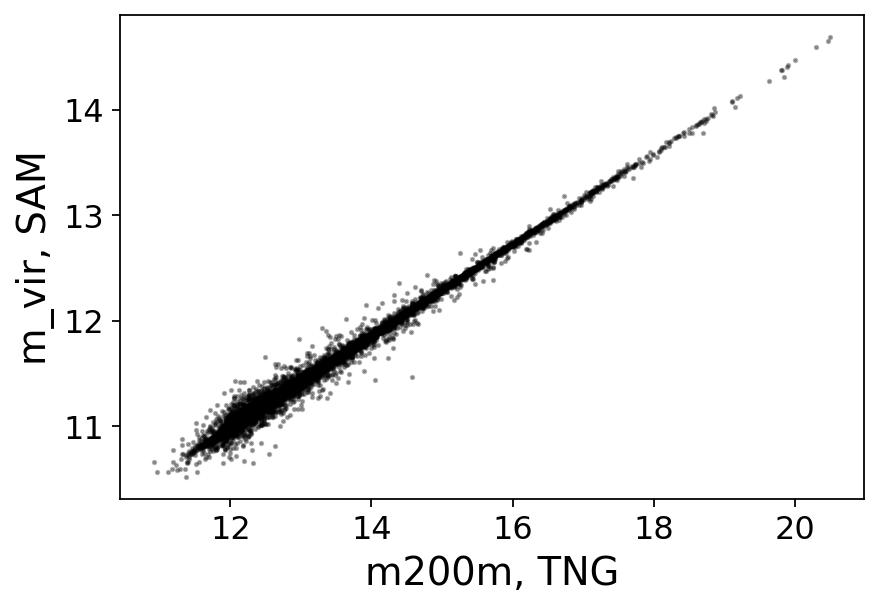

In [34]:
plt.scatter(np.log(m_200m)+log_mass_shift, np.log10(mvir_sam)+log_mass_shift_sam, color='k', alpha=0.3, s=2) 
plt.xlabel('m200m, TNG')
plt.ylabel('m_vir, SAM')

## Visualizing MAHs

In [35]:
sim_reader.add_MAH_to_halos_SAM()

In [36]:
np.random.seed(14)
rand_idxs = np.random.randint(len(sim_reader.dark_halo_arr), size=10)

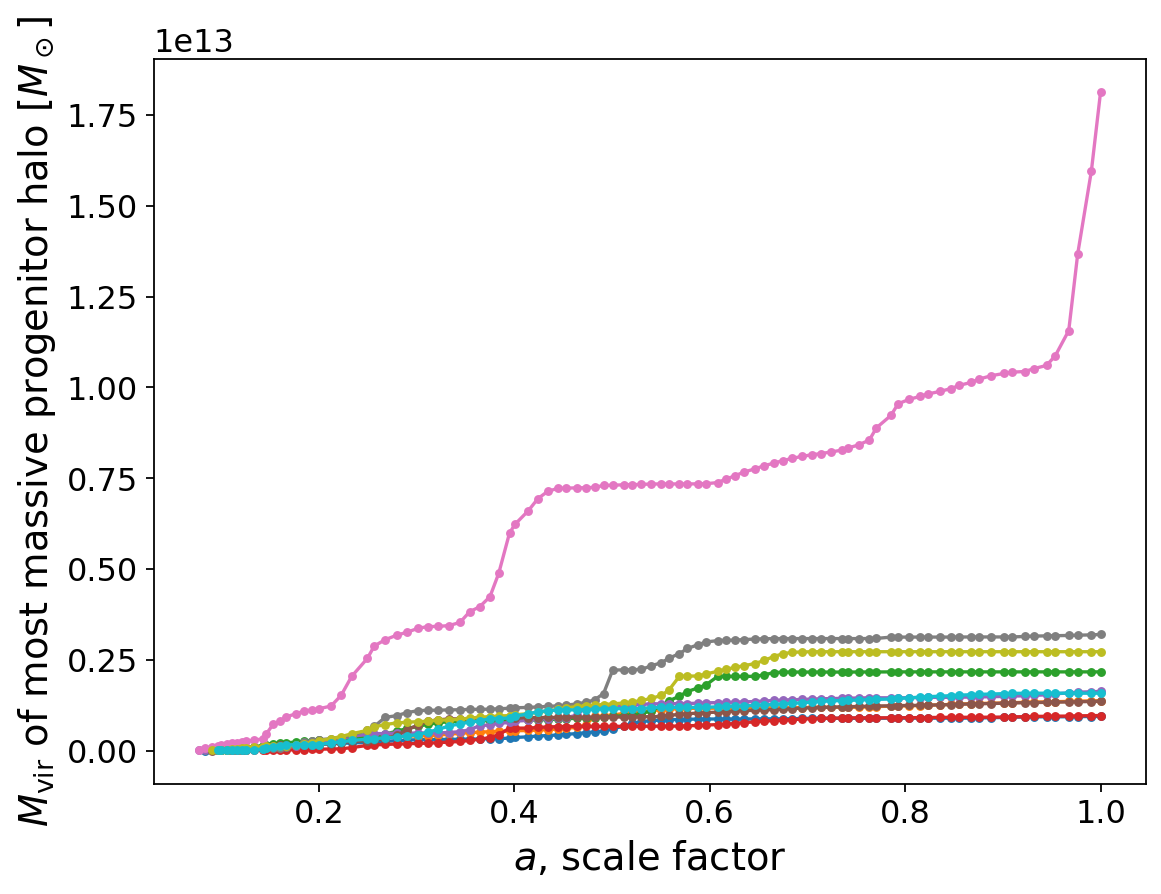

In [37]:
plt.figure(figsize=(8,6))
for i in rand_idxs:
    halo = sim_reader.dark_halo_arr[i]
    a_mah, m_mah = halo.catalog_properties['MAH']
    plt.plot(a_mah, m_mah*mass_multiplier, marker='o', markersize=3)
    plt.xlabel(r'$a$, scale factor')
    plt.ylabel(r'$M_\mathrm{vir}$ of most massive progenitor halo [$M_\odot$]')

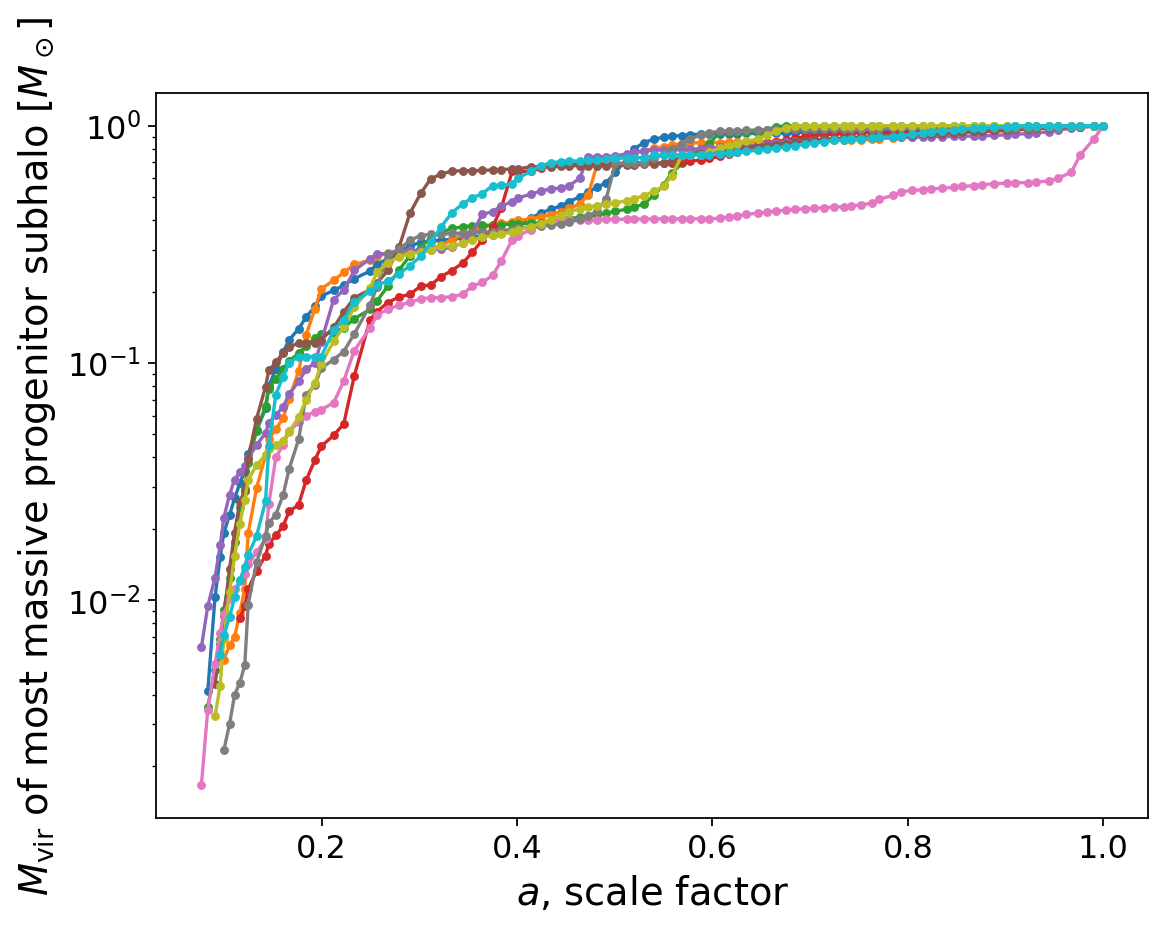

In [38]:
plt.figure(figsize=(8,6))
for i in rand_idxs:
    halo = sim_reader.dark_halo_arr[i]
    a_mah, m_mah = halo.catalog_properties['MAH']
    plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3)
    plt.yscale('log')
    plt.xlabel(r'$a$, scale factor')
    plt.ylabel(r'$M_\mathrm{vir}$ of most massive progenitor subhalo [$M_\odot$]')

In [39]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [40]:
halo = sim_reader.dark_halo_arr[0]
a_mah, m_mah = halo.catalog_properties['MAH']
a_vals = [0.25, 0.5, 0.75]
i_avals = []
for a_val in a_vals:
    a_near, i_a = find_nearest(a_mah, a_val)
    i_avals.append(i_a)
    print(a_near)

0.24948981
0.5006799
0.75254


In [41]:
i_avals

[74, 49, 23]

In [42]:
m_arrs = []
for i_a in i_avals:
    ms = np.zeros(len(sim_reader.dark_halo_arr))
    for i, halo in enumerate(sim_reader.dark_halo_arr):
        if 'MAH' not in halo.catalog_properties or (type(halo.catalog_properties['MAH'])==float and np.isnan(halo.catalog_properties['MAH'])):
            continue
        if len(halo.catalog_properties['MAH'][1]) >= i_a+1:
            ms[i] = halo.catalog_properties['MAH'][1][i_a]
    m_arrs.append(ms)

/state/partition1/job-24173434/ipykernel_4161296/1320846848.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(m_arrs[i] * mass_multiplier), bins=bins)


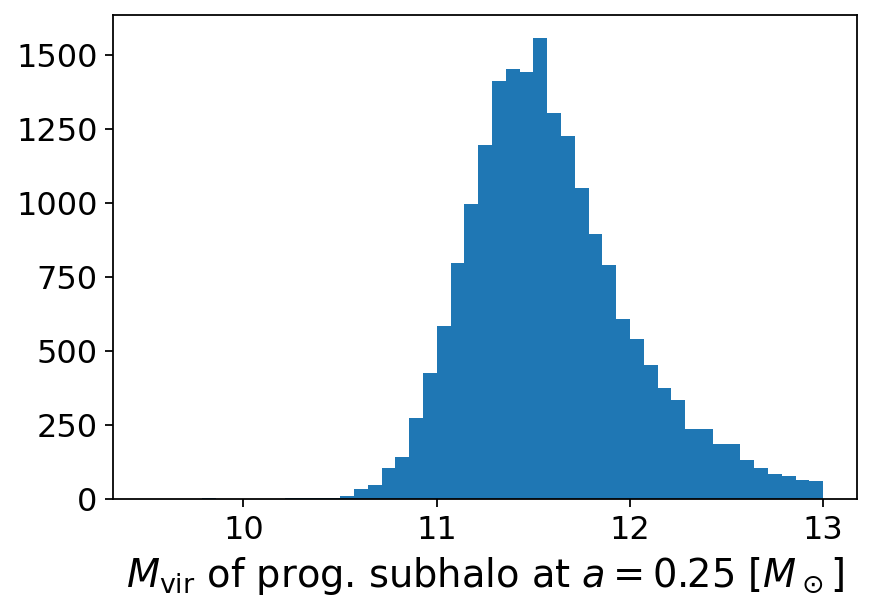

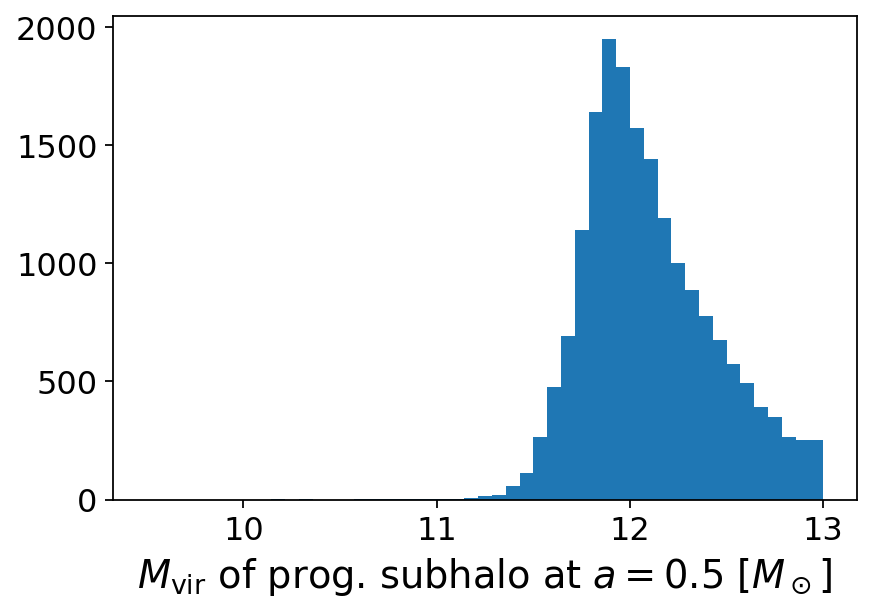

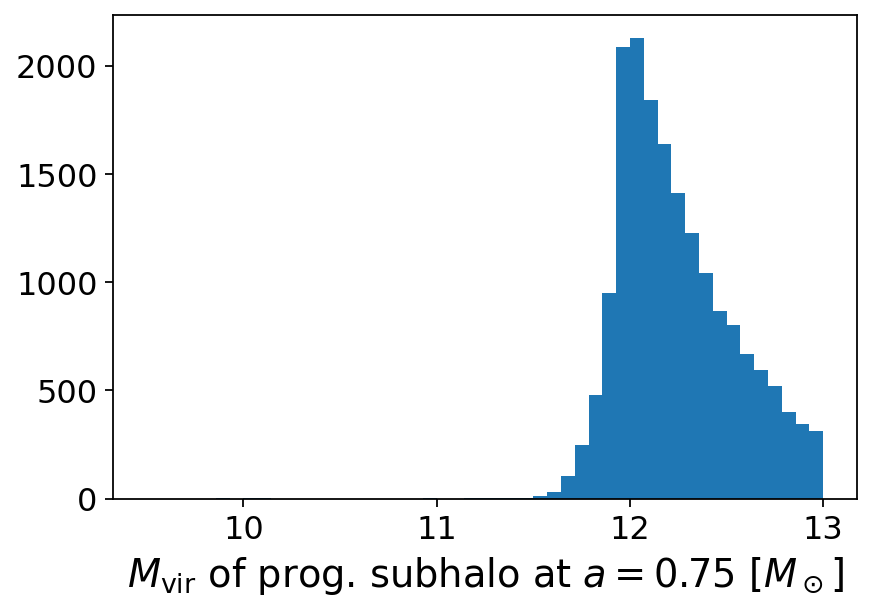

In [43]:
bins = np.linspace(9.5, 13, 50)
for i in range(len(i_avals)):
    plt.figure()
    plt.hist(np.log10(m_arrs[i] * mass_multiplier), bins=bins)
    plt.xlabel(rf'$M_\mathrm{{vir}}$ of prog. subhalo at $a={a_vals[i]}$ [$M_\odot$]')

/state/partition1/job-24173434/ipykernel_4161296/1148778271.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_m_200m + log_mass_shift, np.log10(m_arrs[i]) + log_mass_shift,


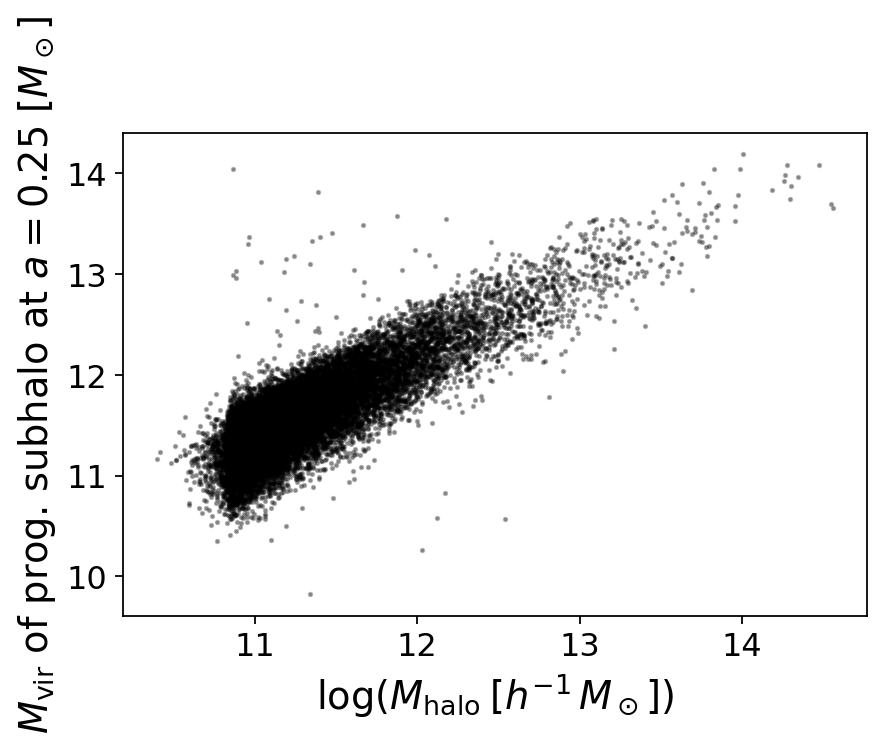

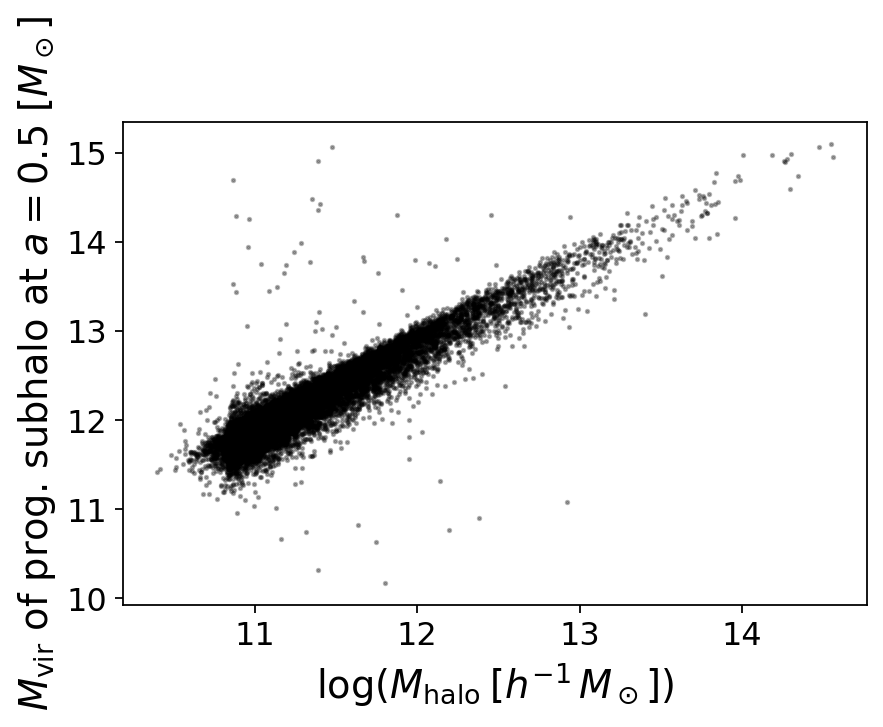

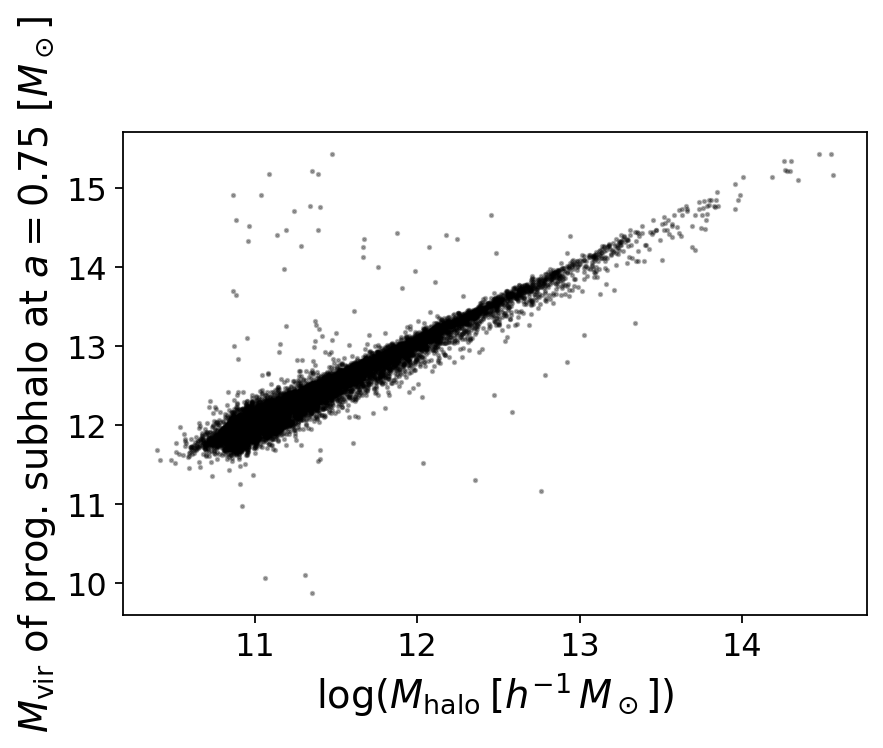

In [44]:
for i in range(len(i_avals)):
    plt.figure(figsize=(6, 4))
    plt.scatter(log_m_200m + log_mass_shift, np.log10(m_arrs[i]) + log_mass_shift, 
                color='k', alpha=0.3, s=2)

    plt.xlabel(utils.label_dict['m_200m'])
    plt.ylabel(rf'$M_\mathrm{{vir}}$ of prog. subhalo at $a={a_vals[i]}$ [$M_\odot$]')

## Load features

In [10]:
# geo info
geo_tag = ''
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)

../configs/geo_TNG100-1.yaml


In [11]:
scalar_tag = ''
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/scalar_TNG100-1.yaml


In [23]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

In [13]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [27]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
15325.841527680936
0.4316602208073314


In [47]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [30]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


## Split train-val-test

In [31]:
frac_train = 0.70
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, frac_test=frac_test)

print(len(idx_train), len(idx_test), len(idx_val))

13769 2951 2950


In [66]:
log_m_200m_train = log_m_200m[idx_train]

# Make predictions

In [49]:
for i in range(len(i_avals)):
#for i in range(2,3):
    print(i)
    x_label_name = 'm_200m'
    y_label_name = 'm_vir'
    
    y_label_vals = np.log10(m_arrs[i])
    #y_label_vals = log_m_200m
    
    idx_zero = y_label_vals == 0
    print(np.sum(idx_zero)/len(idx_zero))
    y_label_vals[idx_zero] = 6 - log_mass_shift

    uncertainties_mah = 0.1 * y_label_vals
    y_val_current_mah = np.ones(len(y_label_vals))
    
    fitter_all = LinearFitter(scalar_featurizer.scalar_features, y_label_vals, 
                        y_val_current_mah, uncertainties=uncertainties_mah,
                        x_features_extra=x_features_extra)
    fitter_all.split_train_test(idx_train, idx_val)
    fitter_all.scale_and_fit(rms_x=True, log_x=False, log_y=False)
    fitter_all.predict_test()
    plotter.plot_fits(x_label_name, y_label_name, fitter_all, log_m_200m, x_lim=(9,14),  y_lim=(9,14))
    error_all, _ = utils.compute_error(fitter_all, test_error_type='percentile')
    print(error_all)
    
    y_true = fitter_all.y_scalar_test
    y_pred = fitter_all.y_scalar_pred
    print(np.min(y_true), np.max(y_true))
    print(np.min(y_pred), np.max(y_pred))
    error_str = fr"$\sigma_{{68}}$: {error_all:.3f}"
    plotter.plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str,
                                   x_lim=(9,14),  y_lim=(9,14))

0
0.0


/state/partition1/job-24173434/ipykernel_4161296/1301432365.py:7: RuntimeWarning: divide by zero encountered in log10
  y_label_vals = np.log10(m_arrs[i])



Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


LinAlgError: SVD did not converge in Linear Least Squares

# 